# Assignment 2: Evaluating Classification Models - Oscar Hernandez 

## Purpose

The purpose of this report is to outline the work that was involved as part of our advisory role with a Portuguese Bank. The bank is interested in identifying factors that affect client responses to new term deposit offerings. They conducted seventeen telephone marketing campaigns between May 2008 and November 2010. They have supplied us with this customer data which includes a variety of variables such as level of education, type of job and age. One of our end goals is to advise the bank which machine learning model will be most beneficial to their telephone marketing campaigns. 

#### This report will be broken up into Sections that cover the specific methodology that went into arriving at the final recommendation. The report will include and/or cover, at minimum, the following specific items and/or tasks:
* Utilize the Bank Marketing Study data to build several classifiers that will help drive decision making 
* Use three binary explanatory variables relating to client banking history: default, housing and loan 
* The binary response variable will answer: Has the client subscribed to a term deposit? 
* We will only utilize observations in the data set that no missing values for the variables of interest 
* Develop two classifiers - Logistic Regression and Naïve Bayes  
* Use K-fold cross-validation to validate these classifiers along with AUC as an index of classification performance 
* Provide final recommendation to the bank we are advising which includes stating which model is the best and why. Also, we will tell the bank which group of banking clients appears to be the best target for direct marketing efforts. 


### Section 1 - Exploratory Data Analysis

#### The first step in building a machine learning model is to gain a firm understanding of the data that will be used to train the model. Section 1 covers all the work that was completed as part of the Exploratory Data Analysis (EDA) process along with comments explaining code and output wherever necessary. 

In [95]:
#Load all the necessary packages we need to complete the exercise

import pandas as pd
import numpy as np
import matplotlib as plt
import nbconvert
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [21]:
#Load the data set provided to us from the bank 
bank_input = pd.read_csv("bank.csv", sep = ";")

In [22]:
#This method outputs descriptive statistics
#Gives useful insight into numerical features
bank_input.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [24]:
#This method lets us quickly see if we have any missing values
bank_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
response     4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB


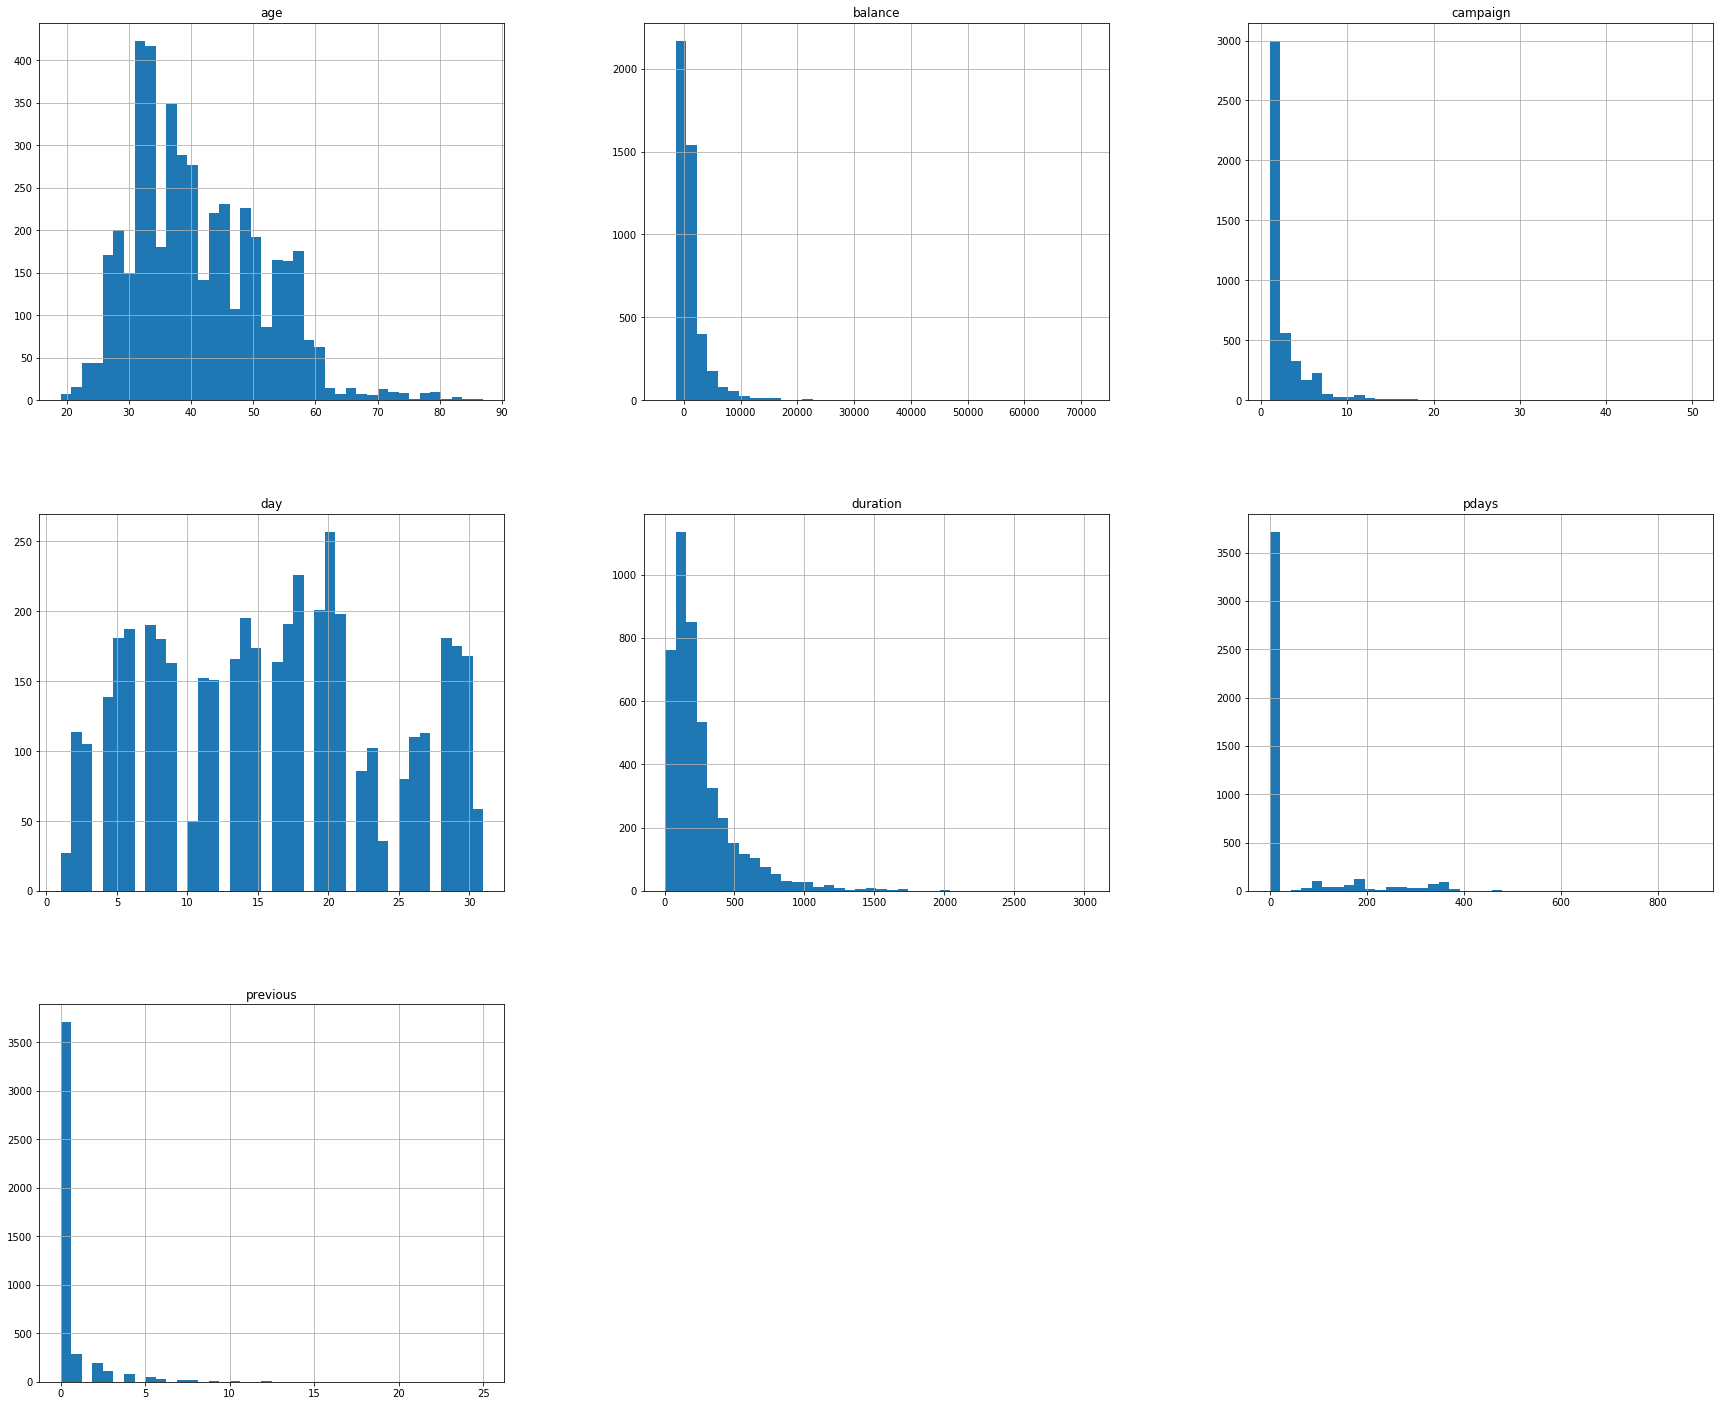

In [25]:
#Let's plot the distribution of some features
#This provides us with visual insight of our features
%matplotlib inline
bank_input.hist(bins = 40, figsize=(30,25));

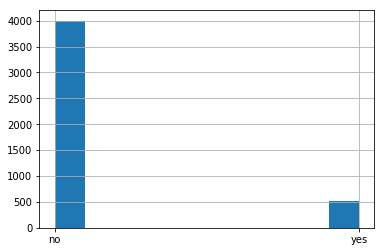

In [110]:
#let's inspect the label - response
bank_input["response"].hist();

###### Key Takeaways (nonexhaustive)
* It appears that the majority of the features are categorical 
* The majority of the customers are in their mid-30s
* Some of the numerical features seem to be zero-inflated 
* The data set did not contain any missing values 
* Majority of the customers rejected the term deposit offer

### Section 2 - Data Preparation 

#### Upon completing the initial EDA process, we got a better understanding of the features that make up the data set. The next section in this exercise is to prepare the data that will be used to train the classifiers.  Typically, this step involves imputing missing values, determining how to deal with outliers, and fixing any erroneous values. Also, variable transformation and feature scaling must be considered as well during this step. 

In [46]:
#Make a copy of the original data set
bank = bank_input.copy()

In [48]:
#Reduce the data set to the proper features and label
bank = bank[["default", "housing", "loan", "response"]]

In [38]:
#Convert text no/yes to integer 0/1
bank.replace(('yes', 'no'), (1, 0), inplace=True)

In [92]:
default = bank["default"]
housing = bank["housing"]
loan = bank["loan"]
response = bank["response"]

#Put these variables into one array
bank_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T


##### Key Takeaways
* This section focused on reducing the initial data set to the main features
* We converted all the text responses to binary responses
* Features did not have missing values so there wasn't a need to impute

### Section 3 - Build Models and Validate Model 

#### Now we will build a Logistic Regression and Naïve Bayes classification model based on the updated training data. We will continue to utilize Scikit-Learn in this section. Since this is a supervised learning exercise, we will have the labels separated as well. 

#### Evaluating each model based on an objective criteria is necessary to understand each model's effectiveness. For classification problems, we are interested in how well each model can correctly classify new instances that it would receive when in production. Predictive accuracy is of upmost importance because the bank we are advising will potentially utilize the classifier we recommend for future direct marketing efforts

In [106]:
#Initialize the classifiers that we want to use 
#Code credit belongs to "jump-start-bank-v003-plus-solution.py" file
#from Marketing Data Science: Modeling Techniques
#for Predictive Analytics with R and Python (Miller 2015)
#jump-start code revised by Thomas W. Milller (2018/10/07)

names = ["Naive_Bayes", "Logistic_Regression"]
classifiers = [BernoulliNB(alpha=1.0, binarize=0.5, 
                           class_prior = [0.5, 0.5], fit_prior=False), 
               LogisticRegression()]

In [102]:
#Specify the # of folds and random seed
r_seed = 10
N_FOLDS = 4

In [111]:
#Complete the K-Fold validation 
cv_results = np.zeros((N_FOLDS, len(names)))
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = r_seed)

index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(bank_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')    
    X_train = bank_data[train_index, 0:bank_data.shape[1]-1]
    X_test = bank_data[test_index, 0:bank_data.shape[1]-1]
    y_train = bank_data[train_index, bank_data.shape[1]-1]
    y_test = bank_data[test_index, bank_data.shape[1]-1]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1]) 
        print('Area under ROC curve:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(cv_results_df.mean())   


Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (3390, 3)
X_test: (1131, 3)
y_train: (3390,)
y_test: (1131,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.60936259542

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Area under ROC curve: 0.60936259542

Fold index: 1 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (3391, 3)
X_test: (1130, 3)
y_train: (3391,)
y_test: (1130,)

Classifier evaluation for: Naive_Bayes
  Scikit 

##### Key Takeaways
* This section was straight-forward in the sense that Scikit-Learn was utilized to create both models
* A 4-fold cross-validation was utilized which resulted in identical answers for both models
* The AUC for both models was 0.607 which is not terribly good. An AUC closer to 1 is preferred 

### Section 5 - Final Recommendation

In [109]:
#Code credit belongs to "jump-start-bank-v003-plus-solution.py" file
#from Marketing Data Science: Modeling Techniques
#for Predictive Analytics with R and Python (Miller 2015)
#jump-start code revised by Thomas W. Milller (2018/10/07)

my_default = np.array([1, 1, 1, 1, 0, 0, 0, 0], np.int32)
my_housing = np.array([1, 1, 0, 0, 1, 1, 0, 0], np.int32)
my_loan = np.array([1, 0, 1, 0, 1, 0, 1, 0], np.int32)

my_X_test = np.vstack([my_default, my_housing, my_loan]).T

# Fit the logistic regression model since it had the same 
# performance as the nb model
clf = LogisticRegression()
X_train = bank_data[:, 0:bank_data.shape[1]-1]
y_train = bank_data[:, bank_data.shape[1]-1]
clf.fit(X_train, y_train)

# Predict specific test cases
y_my_test_predict = clf.predict_proba(my_X_test)

# create DataFrame for displaying test cases and predicted probabilities
my_targeting_df = pd.DataFrame(np.hstack([my_X_test, y_my_test_predict]))
my_targeting_df.columns = ['default', 'housing', 'loan', 
                           'predict_NO', 'predict_YES']
print('\n\nLogistic regression model predictions for test cases:')
print(my_targeting_df) 



Logistic regression model predictions for test cases:
   default  housing  loan  predict_NO  predict_YES
0      1.0      1.0   1.0    0.945729     0.054271
1      1.0      1.0   0.0    0.892349     0.107651
2      1.0      0.0   1.0    0.900786     0.099214
3      1.0      0.0   0.0    0.811988     0.188012
4      0.0      1.0   1.0    0.953277     0.046723
5      0.0      1.0   0.0    0.906588     0.093412
6      0.0      0.0   1.0    0.914016     0.085984
7      0.0      0.0   0.0    0.834890     0.165110


From the EDA section of the exercise, we learned that not many customers accepted the bank's direct offer. This was important information because we could look at the features of the customers that did accept the offer in more detail since it was a lot smaller. However, this is not something that would be ideal for a larger data set. 

After training both classifiers, we arrived at the same result. The results were not extremely promising from simply looking at the AUC score which was approximately 61%. However, we can conclude that both classifer are better than random classifier. 

In summary, we can conclude that either model would be ideal for the bank given that the results were identical. Although this is not a common occurrence, it is still valid. Furthermore, we would advise the bank to focus their attention on customers that have credit in default but no mortgage or personal loans. The logistic regression model predicts that approximately 18% of customers would say yes to a term deposit offer over the phone. The next likely customer segment is customers that don't have credit in default and no mortage or personal loans. 